In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [2]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pylab

## Kalman filtering of time series

In [10]:
tar = pd.read_csv('./data/tar2.dat', header=None)
thx = pd.read_csv('./data/thx.dat', header=None)
thx[0] = thx[0].apply(lambda x: x.strip())
thx[[0,1]] = thx[0].str.split('  ',expand=True)
thx[0] = thx[0].apply(lambda x: float(x)) 
thx[1] = thx[1].apply(lambda x: float(x))

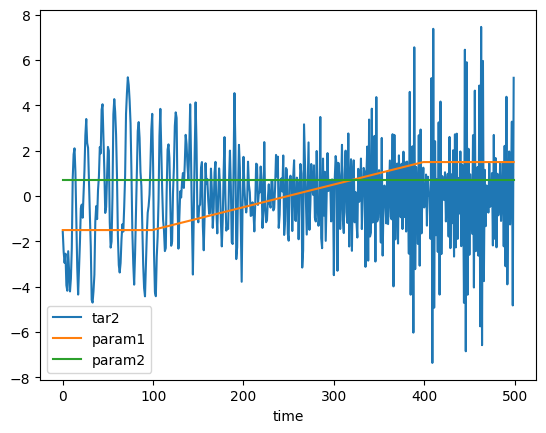

In [15]:
plt.plot(tar, label='tar2')
plt.plot(thx, label=['param1','param2'])
plt.legend()
plt.xlabel('time')
plt.show()

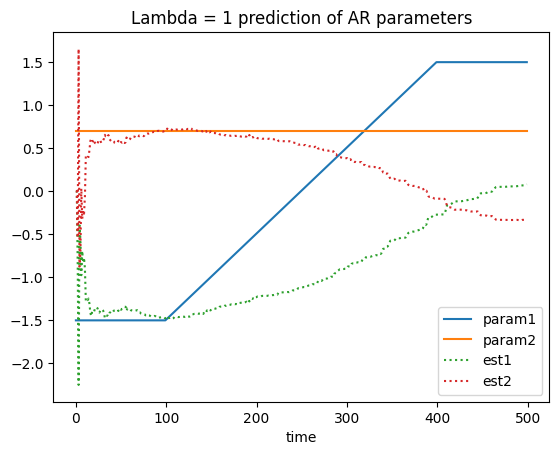

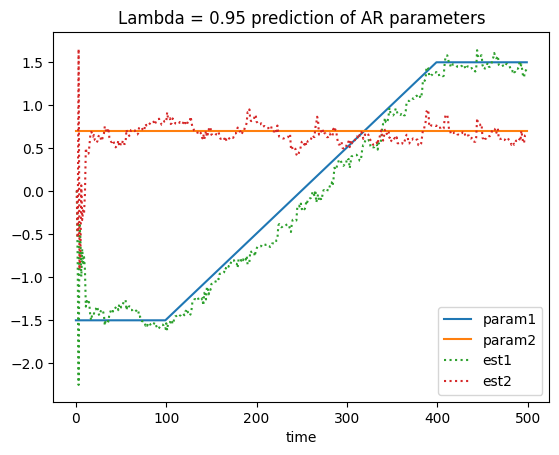

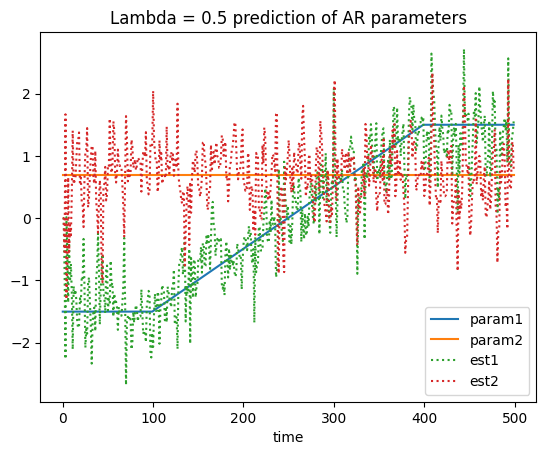

In [33]:
forgetting_factors=[1, .95, .9]
for forgetting_factor in forgetting_factors:
    Aest, yhat = modelling.recursiveAR(data=tar[0], order=2, forgetting_factor=forgetting_factor)
    plt.plot(thx, label=['param1', 'param2'])
    plt.plot(Aest, label=['est1', 'est2'],linestyle = 'dotted')
    plt.legend()
    plt.xlabel('time')
    plt.title(f'Lambda = {forgetting_factor} prediction of AR parameters')
    plt.show()

$\lambda$ the lower the lambda, the more volatile ar estimates are and it reflects changes faster

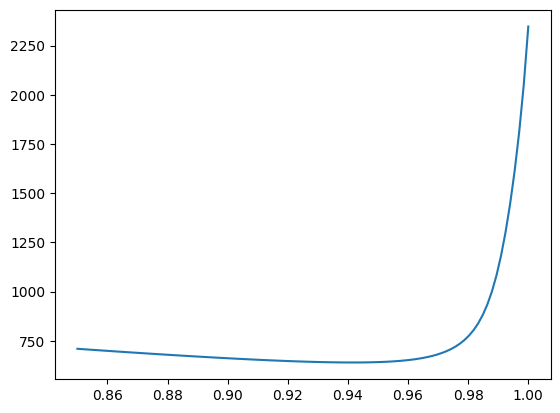

In [57]:
n = 100
lambda_line = np.linspace(.85, 1, n)
ls2 = np.zeros(n)
yhat = np.zeros(n)
for i in range(len(lambda_line)):
    Aest, yhat = modelling.recursiveAR(data=tar[0], order=2, forgetting_factor=lambda_line[i])
    # ls2[i] = sum([(tar[0][i] - yhat[i])**2 for i in range(len(lambda_line))])
    ls2[i] = sum(np.square(np.subtract(tar[0], yhat)))
    
plt.plot(lambda_line, ls2)
plt.show()

[]

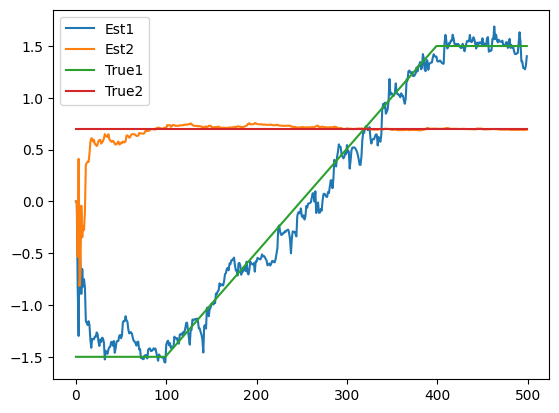

In [116]:
# Kalman filtering
y = tar[0]
N = len(y)
A = np.eye(2)
Re = np.array([[.004, 0], [0, 0]])
Rw = 1.25

Rxx1 = 10 * np.eye(2)
xtt1 = np.array([0, 0]).reshape(-1, 1)

Xsave = np.zeros((2, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
yt1 = np.zeros(N)
yt2 = np.zeros(N)

for t in range(2, N):
    Ct = -np.array([y[t - 1], y[t - 2]]).reshape(1, -1)
    yhat[t] = np.dot(Ct, xtt1).item()
    ehat[t] = y[t] - yhat[t]

    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    xtt = xtt1 + np.dot(Kt, ehat[t])
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, xtt)
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re

    Xsave[:, t] = xtt.flatten()

plt.plot(Xsave[0], label='Est1')
plt.plot(Xsave[1], label='Est2')
plt.plot(thx[0], label='True1')
plt.plot(thx[1], label='True2')
plt.legend()
plt.plot()

The greater the Rw, the longer it takes for the estimated x values to reach its true value \
The bigger the Re, the noisier the estimated values are \
We can find the optimal Re and Rw that minimizes the sum of squared residuals \

**Not sure** about the following question. \
Did you manage to improve the estimation by using Kalman filtering instead of RLS?

In [104]:
# Sum of squared residual
sum(np.square(ehat))

606.7169391166389

## Using the Kalman filter for prediction

[]

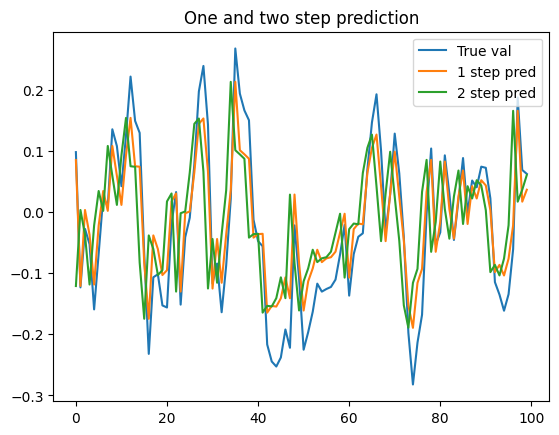

In [145]:
# Kalman filtering
# y = tar[0]
N = 10000
A0 = [1, -.8, .2]
ee = .1 * np.random.randn(N)
y = modelling.filter(1, A0, ee)
A = np.eye(2)
Re = np.array([[1e-6, 0], [0, 1e-6]])
Rw = .1

Rxx1 = 10 * np.eye(2)
xtt1 = np.array([0, 0]).reshape(-1, 1)

Xsave = np.zeros((2, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
yt1 = np.zeros(N)
yt2 = np.zeros(N)

for t in range(2, N-2):
    Ct = -np.array([y[t - 1], y[t - 2]]).reshape(1, -1)
    yhat[t] = np.dot(Ct, xtt1).item()
    ehat[t] = y[t] - yhat[t]

    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    xtt = xtt1 + np.dot(Kt, ehat[t])
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, xtt)
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re

    # One-step prediction
    Ct1 = -np.array([y[t], y[t - 1]]).reshape(1, -1)
    yt1[t + 1] = np.dot(Ct1, xtt).item()

    # Two-step prediction
    Ct2 = -np.array([y[t + 1], y[t]]).reshape(1, -1)
    yt2[t + 2] = np.dot(Ct2, xtt).item()
    
    Xsave[:, t] = xtt.flatten()

plt.plot(y[N-100-3:N-3], label='True val')
plt.plot(yt1[N-100-2:N-2], label='1 step pred')
plt.plot(yt2[N-100-1:N-1], label='2 step pred')
plt.legend()
plt.title('One and two step prediction')
plt.plot()

[]

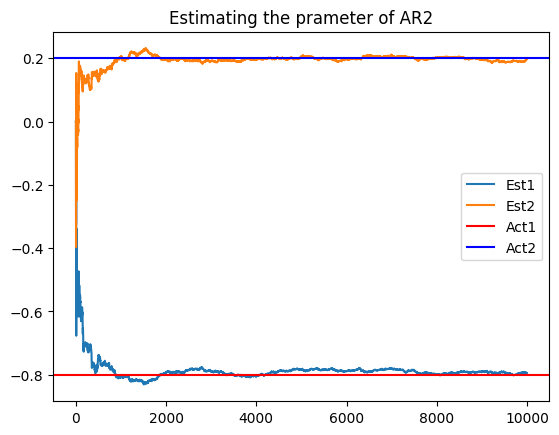

In [143]:
plt.plot(Xsave[0,:-2], label='Est1')
plt.plot(Xsave[1,:-2], label='Est2')
plt.axhline(y = A0[1], color = 'r', linestyle = '-', label='Act1') 
plt.axhline(y = A0[2], color = 'b', linestyle = '-', label='Act2') 
plt.legend()
plt.title('Estimating the prameter of AR2')
plt.plot()

In [159]:
one_step_pred_error = sum(np.square(np.subtract(y,yt1))[N-100-2:N-2])
two_step_pred_error = sum(np.square(np.subtract(y,yt2))[N-100-1:N-1])
print(f'The one step prediction error is {round(one_step_pred_error,4)}')
print(f'The two step prediction error is {round(two_step_pred_error,4)}')

The one step prediction error is 0.7989
The two step prediction error is 0.7565


## Quality control of a process

In [ ]:
# Simulate u_t
def sim_u(n, initial_state=1):
    result = []
    curr_state = initial_state
    for i in range(n)
        if curr_state=1:
            next_state = np.random.choice([1,2], 1, p=[7/8,1/8])
        else:
            next_state = np.random.choice([1,2], 1, p=[1/8,7/8])
        result.append(next_state)
        curr_state = next_state
    return result


N = 10000
ut = sim_u(N)
A = 1
b = 20
Ct=1
sigma_e = 1
sigma_v = 4

ee = .1 * np.random.randn(N)
y = modelling.filter(1, A0, ee)

Re = np.array([[1e-6, 0], [0, 1e-6]])
Rw = .1

Rxx1 = 10 * np.eye(2)
xtt1 = np.array([0, 0]).reshape(-1, 1)

Xsave = np.zeros((2, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
yt1 = np.zeros(N)
yt2 = np.zeros(N)

for t in range(2, N-2):
    Ct = -np.array([y[t - 1], y[t - 2]]).reshape(1, -1)
    yhat[t] = np.dot(Ct, xtt1).item()
    ehat[t] = y[t] - yhat[t]

    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    xtt = xtt1 + np.dot(Kt, ehat[t])
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, xtt)
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re

    # One-step prediction
    Ct1 = -np.array([y[t], y[t - 1]]).reshape(1, -1)
    yt1[t + 1] = np.dot(Ct1, xtt).item()

    # Two-step prediction
    Ct2 = -np.array([y[t + 1], y[t]]).reshape(1, -1)
    yt2[t + 2] = np.dot(Ct2, xtt).item()
    
    Xsave[:, t] = xtt.flatten()

